In [1]:
import os
from dotenv import load_dotenv
import requests
import json
from urllib.request import urlretrieve
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from ydata_profiling import ProfileReport
import pickle

In [2]:
load_dotenv()

BLS_API_KEY = os.getenv('BLS_key')

*****
Import Job Opening Statistics from Bureau of Labor
*****

In [3]:
#Bureau of Labor Statistics API
#Job Openings and Labor Turnover Survey Series ID codification
prefix = "JT" #Prefix
seasonal = "U" #Non seasonal adjusted
industry = "000000" #Total nonfarm industry
state = "00" #Total US
area = "00000" #All areas
size = "00" #All size classes
stat = "JO" #Job Openings
pay = "L" #Pay level in thousands
JOLTS_ID = prefix + seasonal + industry + state + area + size + stat + pay
print(JOLTS_ID)

JTU000000000000000JOL


In [4]:
#Create lookup tables for State codes to use in BLS API
xls = pd.ExcelFile('../Data/BLS_data_dict.xlsx')
state_codes = xls.parse(xls.sheet_names[0])
state_codes_filtered = state_codes[1:52] #filter for states only
state_codes_filtered = state_codes_filtered[state_codes_filtered['state_code'] != 11].reset_index() #remove DC
del state_codes_filtered['index']
state_codes_dict = dict(zip(state_codes_filtered.state_code, state_codes_filtered.state_text))
print(state_codes_dict)

{'01': 'Alabama', '02': 'Alaska', '04': 'Arizona', '05': 'Arkansas', '06': 'California', '08': 'Colorado', '09': 'Connecticut', 10: 'Delaware', 12: 'Florida', 13: 'Georgia', 15: 'Hawaii', 16: 'Idaho', 17: 'Illinois', 18: 'Indiana', 19: 'Iowa', 20: 'Kansas', 21: 'Kentucky', 22: 'Louisiana', 23: 'Maine', 24: 'Maryland', 25: 'Massachusetts', 26: 'Michigan', 27: 'Minnesota', 28: 'Mississippi', 29: 'Missouri', 30: 'Montana', 31: 'Nebraska', 32: 'Nevada', 33: 'New Hampshire', 34: 'New Jersey', 35: 'New Mexico', 36: 'New York', 37: 'North Carolina', 38: 'North Dakota', 39: 'Ohio', 40: 'Oklahoma', 41: 'Oregon', 42: 'Pennsylvania', 44: 'Rhode Island', 45: 'South Carolina', 46: 'South Dakota', 47: 'Tennessee', 48: 'Texas', 49: 'Utah', 50: 'Vermont', 51: 'Virginia', 53: 'Washington', 54: 'West Virginia', 55: 'Wisconsin', 56: 'Wyoming'}


In [5]:
#Create series ids to use for API request
series_ids = []
series_ids_sznadj = []
series_ids_overflow = []
series_ids_overflow_sznadj = []

for code in state_codes_dict:
    JOLTS_ID = prefix + seasonal + industry + str(code) + area + size + stat + pay
    JOLTS_ID_sznadj = prefix + "S" + industry + str(code) + area + size + stat + pay
    if len(series_ids) < 50: #API limits to 50 series. This will be used for request.
        series_ids.append(JOLTS_ID)
        series_ids_sznadj.append(JOLTS_ID_sznadj)
    else: #store any excess series in seperate list for further accessment
        series_ids_overflow.append(JOLTS_ID)
        series_ids_overflow_sznadj.append(JOLTS_ID_sznadj)

#print(series_ids)
#print(series_ids_sznadj)
print(series_ids_overflow)
print(series_ids_overflow_sznadj)

[]
[]


In [6]:
#Request state level data from BLS using series created earlier
start_year = "2004"
end_year = "2023"

headers = {'Content-type': 'application/json'}
data = json.dumps({"seriesid": series_ids,"startyear":start_year, "endyear":end_year, "registrationkey":BLS_API_KEY})
p = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', data=data, headers=headers)
json_data = json.loads(p.text)

In [7]:
#Request state level data from BLS using series created earlier (Seasonally adjusted)
headers = {'Content-type': 'application/json'}
data = json.dumps({"seriesid": series_ids_sznadj,"startyear":start_year, "endyear":end_year, "registrationkey":BLS_API_KEY})
p = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', data=data, headers=headers)
json_data_szn = json.loads(p.text)

In [8]:
#Aggregate all state level detail into one dataframe
dfs = []
for x in range(len(series_ids)):
    state_df = pd.DataFrame(json_data['Results']['series'][x]['data'])
    state_df['state'] = state_codes_filtered.iloc[x,1]
    dfs.append(state_df)

JOLTS_df = pd.concat(dfs)
del JOLTS_df['footnotes']
JOLTS_df['value'] = JOLTS_df['value'].astype(int)
JOLTS_df['period'] = JOLTS_df['period'].str.replace('M','')
JOLTS_df['period_dt'] = pd.to_datetime(JOLTS_df['year'] + '-' + JOLTS_df['period'])
JOLTS_df.sort_values(by = ['state','period_dt'], ascending = [True,True], inplace=True)
print(JOLTS_df)
print(JOLTS_df.info())
print(JOLTS_df.describe())

     year period periodName  value    state  period_dt
239  2004     01    January     64  Alabama 2004-01-01
238  2004     02   February     49  Alabama 2004-02-01
237  2004     03      March     53  Alabama 2004-03-01
236  2004     04      April     63  Alabama 2004-04-01
235  2004     05        May     60  Alabama 2004-05-01
..    ...    ...        ...    ...      ...        ...
4    2023     08     August     19  Wyoming 2023-08-01
3    2023     09  September     18  Wyoming 2023-09-01
2    2023     10    October     18  Wyoming 2023-10-01
1    2023     11   November     15  Wyoming 2023-11-01
0    2023     12   December     22  Wyoming 2023-12-01

[12000 rows x 6 columns]
<class 'pandas.core.frame.DataFrame'>
Index: 12000 entries, 239 to 0
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   year        12000 non-null  object        
 1   period      12000 non-null  object        
 2   periodName  1200

In [9]:
profile = ProfileReport(JOLTS_df, title="JOLTS Profiling Report")
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\Brendan\anaconda3\Lib\site-packages\ydata_profiling\model\correlations.py:66: UserWarning: There was an attempt to calculate the auto correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"auto": {"calculate": False}})`
If this is problematic for your use case, please report this as an issue:
https://github.com/ydataai/ydata-profiling/issues
(include the error message: 'cannot reindex on an axis with duplicate labels')
  warnings.warn(


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

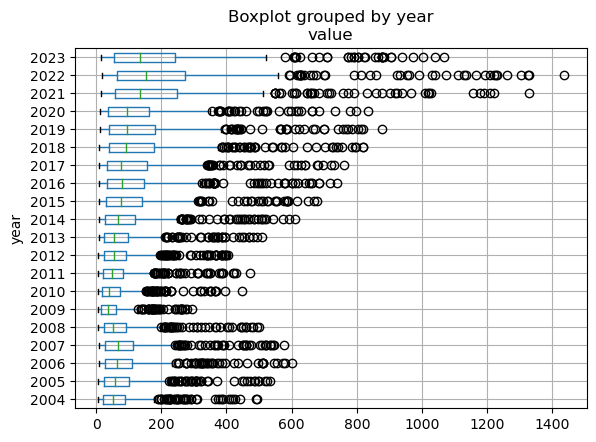

In [10]:
plt.clf()
JOLTS_df.boxplot(column='value', by='year', vert=False)
plt.show()

In [11]:
JOLTS_df[JOLTS_df['year'] == '2022'].sort_values(by = 'value', ascending = False)

,year,period,periodName,value,state,period_dt
17,2022,07,July,1434,California,2022-07-01
19,2022,05,May,1329,California,2022-05-01
20,2022,04,April,1325,California,2022-04-01
14,2022,10,October,1303,California,2022-10-01
21,2022,03,March,1262,California,2022-03-01
...,...,...,...,...,...,...
14,2022,10,October,20,Alaska,2022-10-01
14,2022,10,October,20,Wyoming,2022-10-01
15,2022,09,September,19,Vermont,2022-09-01
16,2022,08,August,19,Vermont,2022-08-01


In [12]:
#Aggregate all state level detail into one dataframe (Seasonally adjusted)
dfs = []
for x in range(len(series_ids)):
    state_df = pd.DataFrame(json_data_szn['Results']['series'][x]['data'])
    state_df['state'] = state_codes_filtered.iloc[x,1]
    dfs.append(state_df)

JOLTS_df_szn = pd.concat(dfs)
del JOLTS_df_szn['footnotes']
JOLTS_df_szn['value'] = JOLTS_df_szn['value'].astype(int)
JOLTS_df_szn['period'] = JOLTS_df_szn['period'].str.replace('M','')
JOLTS_df_szn['period_dt'] = pd.to_datetime(JOLTS_df_szn['year'] + '-' + JOLTS_df_szn['period'])
JOLTS_df_szn.sort_values(by = ['state','period_dt'], ascending = [True,True], inplace=True)
print(JOLTS_df_szn)
print(JOLTS_df_szn.info())
print(JOLTS_df_szn.describe())

     year period periodName  value    state  period_dt
239  2004     01    January     58  Alabama 2004-01-01
238  2004     02   February     51  Alabama 2004-02-01
237  2004     03      March     53  Alabama 2004-03-01
236  2004     04      April     55  Alabama 2004-04-01
235  2004     05        May     57  Alabama 2004-05-01
..    ...    ...        ...    ...      ...        ...
4    2023     08     August     19  Wyoming 2023-08-01
3    2023     09  September     19  Wyoming 2023-09-01
2    2023     10    October     19  Wyoming 2023-10-01
1    2023     11   November     18  Wyoming 2023-11-01
0    2023     12   December     19  Wyoming 2023-12-01

[12000 rows x 6 columns]
<class 'pandas.core.frame.DataFrame'>
Index: 12000 entries, 239 to 0
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   year        12000 non-null  object        
 1   period      12000 non-null  object        
 2   periodName  1200

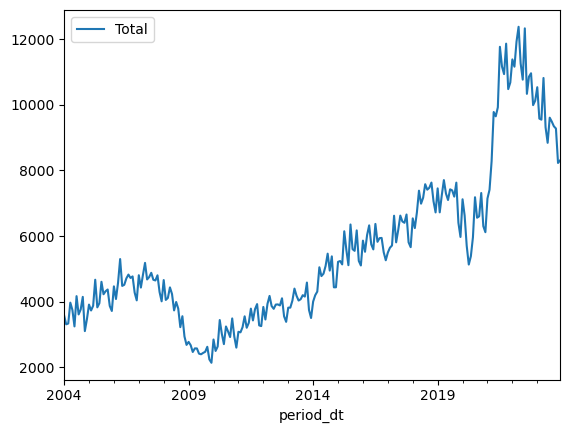

In [13]:
#total line plot
fig, ax = plt.subplots()
group1 = pd.pivot_table(JOLTS_df, values = 'value', index = 'period_dt', aggfunc='sum').reset_index()
group1.plot(x='period_dt',y='value',ax=ax,label="Total")    
plt.show()

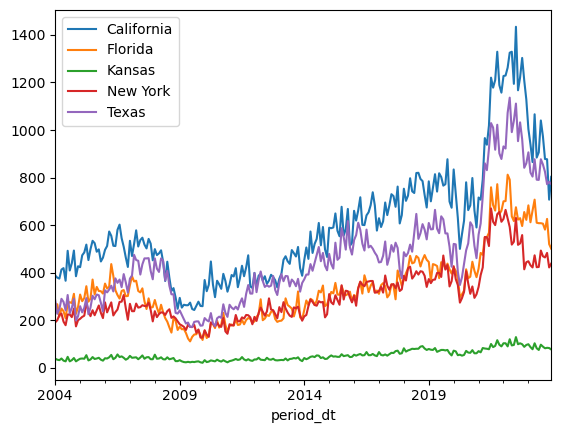

In [14]:
#state level line plot
JOLTS_df_f = JOLTS_df[JOLTS_df['state'].isin(["California","Texas","New York","Florida","Kansas"])]

fig, ax = plt.subplots()
for label, group in JOLTS_df_f.groupby('state'):
    group.plot(x='period_dt',y='value',ax=ax,label=label)

plt.show()

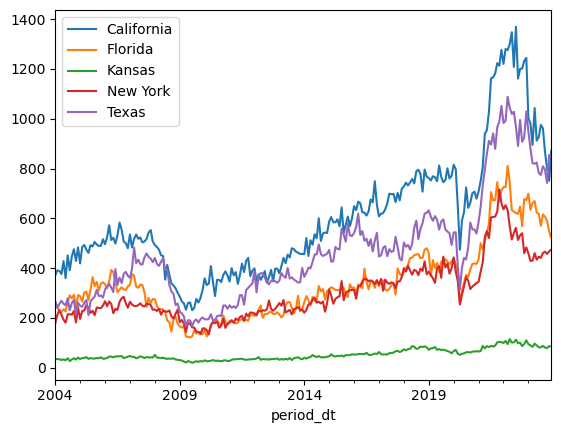

In [15]:
#seasonally adjusted state level line plot
JOLTS_df_f_szn = JOLTS_df_szn[JOLTS_df_szn['state'].isin(["California","Texas","New York","Florida","Kansas"])]

fig, ax = plt.subplots()
for label, group in JOLTS_df_f_szn.groupby('state'):
    group.plot(x='period_dt',y='value',ax=ax,label=label)
    
plt.show()

In [16]:
JOLTS_df = JOLTS_df.rename(columns={'value':'state_job_openings'})
JOLTS_df_szn = JOLTS_df_szn.rename(columns={'value':'state_job_openings_szn_adjd'})

In [17]:
print(JOLTS_df.shape)
print(JOLTS_df.head())

(12000, 6)
     year period periodName  state_job_openings    state  period_dt
239  2004     01    January                  64  Alabama 2004-01-01
238  2004     02   February                  49  Alabama 2004-02-01
237  2004     03      March                  53  Alabama 2004-03-01
236  2004     04      April                  63  Alabama 2004-04-01
235  2004     05        May                  60  Alabama 2004-05-01


In [18]:
print(JOLTS_df_szn.shape)
print(JOLTS_df_szn.head())

(12000, 6)
     year period periodName  state_job_openings_szn_adjd    state  period_dt
239  2004     01    January                           58  Alabama 2004-01-01
238  2004     02   February                           51  Alabama 2004-02-01
237  2004     03      March                           53  Alabama 2004-03-01
236  2004     04      April                           55  Alabama 2004-04-01
235  2004     05        May                           57  Alabama 2004-05-01


In [25]:
JOLTS = pd.merge(JOLTS_df,JOLTS_df_szn[['state','period_dt','state_job_openings_szn_adjd']],on=['state','period_dt'])

In [30]:
print(JOLTS.shape)
print(JOLTS.head())

(12000, 7)
   period_dt  year period periodName    state  state_job_openings  \
0 2004-01-01  2004     01    January  Alabama                  64   
1 2004-02-01  2004     02   February  Alabama                  49   
2 2004-03-01  2004     03      March  Alabama                  53   
3 2004-04-01  2004     04      April  Alabama                  63   
4 2004-05-01  2004     05        May  Alabama                  60   

   state_job_openings_szn_adjd  
0                           58  
1                           51  
2                           53  
3                           55  
4                           57  


In [28]:
JOLTS.columns

Index(['year', 'period', 'periodName', 'state_job_openings', 'state',
       'period_dt', 'state_job_openings_szn_adjd'],
      dtype='object')

In [29]:
JOLTS = JOLTS[['period_dt', 'year', 'period', 'periodName', 'state', 'state_job_openings','state_job_openings_szn_adjd']]

In [31]:
JOLTS.to_pickle('../Data/JOLTS.pkl')